In [1]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
import matplotlib.image as mpim
import matplotlib.colors as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import ConnectionPatch
import nibabel as nib
from nilearn import image, plotting
import glob
import pandas as pd  # pd is the usual abbreviation for pandas
import seaborn as sns  # seaborn is the main plotting library for Pandas
sns.set(context='paper',
        style='whitegrid')  # use the prettier seaborn plotting settings rather than the default matplotlib one
import ptitprince as pt
from scipy import stats

/well/win-fmrib-analysis/users/sgk882/conda/envs/neuro/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Read in cluster weight data

In [6]:
cluster_weights_list = []
reg_name_dict = {'af':'AF', 't1_x4':'T1-50', 't1_x2':'T1', 'mm_x2':'MM', 'drtamas_mm_1mil':'DRT-MM', 'ants_1mil':'ANTs'}

In [7]:
# Read in text files
for reg in ['af', 't1_x4', 't1_x2', 'mm_x2', 'ants_1mil', 'drtamas_mm_1mil']:
    for task in ['tfMRI_EMOTION','tfMRI_GAMBLING','tfMRI_LANGUAGE','tfMRI_MOTOR','tfMRI_RELATIONAL','tfMRI_SOCIAL','tfMRI_WM']:
        for smooth in ['0']:
            filename = '~/rick_home/multimodal_validation/data/group/OMM/Results/'+task+'_hp200_s'+smooth+'/'+reg+'/'+'cluster_weights.txt'
            tmp_cluster_weights_df = pd.read_csv(filename,sep='\s+')
            tmp_cluster_weights_df.insert(0,'smooth',smooth)
            tmp_cluster_weights_df.insert(0,'task',task[6:])
            tmp_cluster_weights_df.insert(0,'reg',reg)
            cluster_weights_list.append(tmp_cluster_weights_df)
# Concatinate dataframes
cluster_weights_df = pd.concat(cluster_weights_list,ignore_index=True)
cluster_weights_df['cluster_weight'] = cluster_weights_df['mean_tstat']*cluster_weights_df['volume']

contrast_names_df = pd.read_csv('~/rick_home/multimodal_validation/contrasts.txt',sep='\s+')
cluster_weights_df = pd.merge(cluster_weights_df,contrast_names_df)

cluster_weights_df.replace(reg_name_dict,inplace=True)

# Total CW

In [8]:
cluster_weights_df.groupby('reg').sum().sort_values('cluster_weight')

cope  mean_tstat   n_vox     volume  mean_90th_tstat  cluster_weight
reg                                                                         
AF       921  343.073691  799120  6392960.0       654.730146    2.822677e+07
FNIRT    921  377.867018  868727  6949816.0       733.229198    3.406145e+07
ANTs     921  395.688233  883605  7068840.0       781.591290    3.642686e+07
T1-50    921  397.754082  889726  7117808.0       780.298504    3.668773e+07
T1       921  397.764135  895940  7167520.0       782.366161    3.695855e+07
DTI      921  376.726491  955391  7643128.0       741.486201    3.730633e+07
MM       921  396.394883  922268  7378144.0       779.538290    3.784388e+07
DRT-MM   921  389.039831  941661  7533288.0       774.336833    3.799076e+07
MM-1mm   921  397.964695  926867  7414936.0       786.961124    3.825617e+07

## MM vs T1

Uncorrected t-stat = 10.33475368
Uncorrected p-value = 1.24558889e-16
Corrected t-stat = 2.7620791
Corrected p-value = 0.03276379


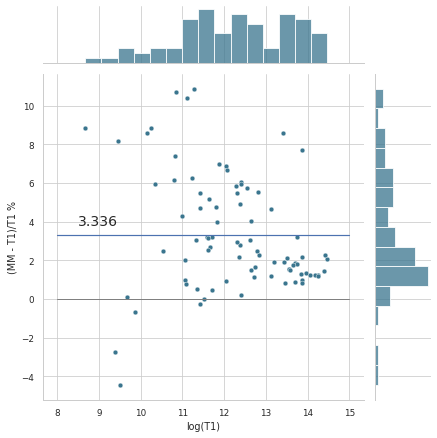

In [10]:
x_ba = (cluster_weights_df.query('reg == "T1" & smooth == "0"')['cluster_weight'].to_numpy())
y_ba = (cluster_weights_df.query('reg == "MM" & smooth == "0"')['cluster_weight'].to_numpy() - cluster_weights_df.query('reg == "T1" & smooth == "0"')['cluster_weight'].to_numpy())
y_ba = y_ba[x_ba > 0]
x_ba = x_ba[x_ba > 0]
y_ba = 100*y_ba/x_ba
x_ba = np.log(x_ba)

fig_r = sns.jointplot(x=x_ba,\
                      y=y_ba,\
                      kind='scatter',\
                      color=sns.cubehelix_palette(n_colors=5, start=4.4, rot=-4, hue=1.0, reverse=True, dark=0.4, light=0.9)[0],\
                      height=6,\
                      marginal_kws=dict(bins=15)
                      )

y_ba_mean = np.mean(y_ba[y_ba != 0])
fig_r.ax_joint.set(ylabel='(MM - T1)/T1 %')
fig_r.ax_joint.set(xlabel='log(T1)')
fig_r.ax_joint.plot([8, 15], [0, 0], linewidth=1.0, color='grey')
fig_r.ax_joint.plot([8, 15], [y_ba_mean, y_ba_mean])
fig_r.ax_joint.text(8.5, y_ba_mean + 0.5, f'{y_ba_mean:.3f}', fontsize=14)

ttest = stats.ttest_1samp(y_ba,0)
print('Uncorrected t-stat = ' + np.array2string(ttest.statistic))
print('Uncorrected p-value = ' + np.array2string(ttest.pvalue))

statistic_adjust = (ttest.statistic/np.sqrt(y_ba.shape[0] - 1))*np.sqrt(6)
pvalue_adjust = stats.t.sf(statistic_adjust,6)*2
print('Corrected t-stat = ' + np.array2string(statistic_adjust))
print('Corrected p-value = ' + np.array2string(pvalue_adjust))

plt.savefig('../../gitlab/multimodal_paper/figs/cm_mm_vs_t1.png', dpi=300,bbox_inches='tight')

## T1 vs AF

Uncorrected t-stat = 10.86561667
Uncorrected p-value = 1.0992101e-17
Corrected t-stat = 2.9039582
Corrected p-value = 0.02719373


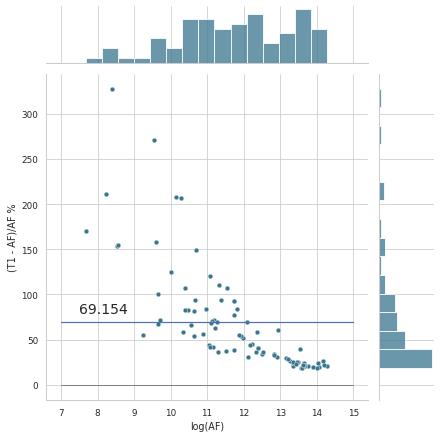

In [10]:
x_ba = (cluster_weights_df.query('reg == "AF" & smooth == "0"')['cluster_weight'].to_numpy())
y_ba = (cluster_weights_df.query('reg == "T1" & smooth == "0"')['cluster_weight'].to_numpy() - cluster_weights_df.query('reg == "AF" & smooth == "0"')['cluster_weight'].to_numpy())
y_ba = y_ba[x_ba > 0]
x_ba = x_ba[x_ba > 0]
y_ba = 100*y_ba/x_ba
x_ba = np.log(x_ba)

fig_r = sns.jointplot(x=x_ba,\
                      y=y_ba,\
                      kind='scatter',\
                      color=sns.cubehelix_palette(n_colors=5, start=4.4, rot=-4, hue=1.0, reverse=True, dark=0.4, light=0.9)[0],\
                      height=6,\
                      marginal_kws=dict(bins=15)
                      )

y_ba_mean = np.mean(y_ba[y_ba != 0])
fig_r.ax_joint.set(ylabel='(T1 - AF)/AF %')
fig_r.ax_joint.set(xlabel='log(AF)')
fig_r.ax_joint.plot([7, 15], [0, 0], linewidth=1.0, color='grey')
fig_r.ax_joint.plot([7, 15], [y_ba_mean, y_ba_mean])
fig_r.ax_joint.text(7.5, y_ba_mean +10, f'{y_ba_mean:.3f}', fontsize=14)

ttest = stats.ttest_1samp(y_ba,0)
print('Uncorrected t-stat = ' + np.array2string(ttest.statistic))
print('Uncorrected p-value = ' + np.array2string(ttest.pvalue))

statistic_adjust = (ttest.statistic/np.sqrt(y_ba.shape[0] - 1))*np.sqrt(6)
pvalue_adjust = stats.t.sf(statistic_adjust,6)*2
print('Corrected t-stat = ' + np.array2string(statistic_adjust))
print('Corrected p-value = ' + np.array2string(pvalue_adjust))

plt.savefig('../../gitlab/multimodal_paper/figs/cm_t1_vs_af.png', dpi=300,bbox_inches='tight')

## MM vs AF

## T1-50 vs T1

Uncorrected t-stat = -6.09183428
Uncorrected p-value = 3.2409862e-08
Corrected t-stat = -1.6281112
Corrected p-value = 1.84537508


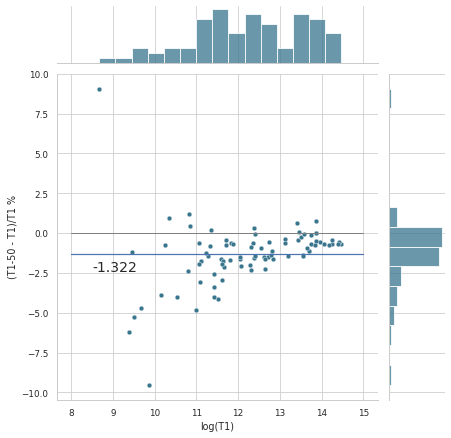

In [25]:
x_ba = (cluster_weights_df.query('reg == "T1" & smooth == "0"')['cluster_weight'].to_numpy())
y_ba = (cluster_weights_df.query('reg == "T1-50" & smooth == "0"')['cluster_weight'].to_numpy() - cluster_weights_df.query('reg == "T1" & smooth == "0"')['cluster_weight'].to_numpy())
y_ba = y_ba[x_ba > 0]
x_ba = x_ba[x_ba > 0]
y_ba = 100*y_ba/x_ba
x_ba = np.log(x_ba)

fig_r = sns.jointplot(x=x_ba,\
                      y=y_ba,\
                      kind='scatter',\
                      color=sns.cubehelix_palette(n_colors=5, start=4.4, rot=-4, hue=1.0, reverse=True, dark=0.4, light=0.9)[0],\
                      height=6,\
                      marginal_kws=dict(bins=15)
                      )

y_ba_mean = np.mean(y_ba[y_ba != 0])
fig_r.ax_joint.set(ylabel='(T1-50 - T1)/T1 %')
fig_r.ax_joint.set(xlabel='log(T1)')
fig_r.ax_joint.plot([8, 15], [0, 0], linewidth=1.0, color='grey')
fig_r.ax_joint.plot([8, 15], [y_ba_mean, y_ba_mean])
fig_r.ax_joint.text(8.5, y_ba_mean -1.05, f'{y_ba_mean:.3f}', fontsize=14)

ttest = stats.ttest_1samp(y_ba,0)
print('Uncorrected t-stat = ' + np.array2string(ttest.statistic))
print('Uncorrected p-value = ' + np.array2string(ttest.pvalue))

statistic_adjust = (ttest.statistic/np.sqrt(y_ba.shape[0] - 1))*np.sqrt(6)
pvalue_adjust = stats.t.sf(statistic_adjust,6)*2
print('Corrected t-stat = ' + np.array2string(statistic_adjust))
print('Corrected p-value = ' + np.array2string(pvalue_adjust))

plt.savefig('../../gitlab/multimodal_paper/figs/cm_t1-50_vs_t1.png', dpi=300,bbox_inches='tight')

## T1 vs FNIRT

In [ ]:
x_ba = (cluster_weights_df.query('reg == "FNIRT" & smooth == "0"')['cluster_weight'].to_numpy())
y_ba = (cluster_weights_df.query('reg == "T1" & smooth == "0"')['cluster_weight'].to_numpy() - cluster_weights_df.query('reg == "FNIRT" & smooth == "0"')['cluster_weight'].to_numpy())
y_ba = y_ba[x_ba > 0]
x_ba = x_ba[x_ba > 0]
y_ba = 100*y_ba/x_ba
x_ba = np.log(x_ba)

fig_r = sns.jointplot(x=x_ba,\
                      y=y_ba,\
                      kind='scatter',\
                      color=sns.cubehelix_palette(n_colors=5, start=4.4, rot=-4, hue=1.0, reverse=True, dark=0.4, light=0.9)[0],\
                      height=6,\
                      marginal_kws=dict(bins=15)
                      )

y_ba_mean = np.mean(y_ba[y_ba != 0])
fig_r.ax_joint.set(ylabel='(T1 - FNIRT)/FNIRT %')
fig_r.ax_joint.set(xlabel='log(FNIRT)')
fig_r.ax_joint.plot([8, 15], [0, 0], linewidth=1.0, color='grey')
fig_r.ax_joint.plot([8, 15], [y_ba_mean, y_ba_mean])
fig_r.ax_joint.text(8.1, y_ba_mean + 4, f'{y_ba_mean:.3f}', fontsize=14)

ttest = stats.ttest_1samp(y_ba,0)
print('Uncorrected t-stat = ' + np.array2string(ttest.statistic))
print('Uncorrected p-value = ' + np.array2string(ttest.pvalue))

statistic_adjust = (ttest.statistic/np.sqrt(y_ba.shape[0] - 1))*np.sqrt(6)
pvalue_adjust = stats.t.sf(statistic_adjust,6)*2
print('Corrected t-stat = ' + np.array2string(statistic_adjust))
print('Corrected p-value = ' + np.array2string(pvalue_adjust))

plt.savefig('../../gitlab/multimodal_paper/figs/cm_t1_vs_fnirt.png', dpi=300,bbox_inches='tight')

## Log-Jacobian Determinant Ranges

In [36]:
jac_dets_list = []
# Read in text files
for reg in ['t1_x4', 't1_x2', 'mm_x2', 'ants_1mil', 'drtamas_mm_1mil']:
    filename = '~/rick_home/multimodal_validation/data/group/OMM/Results/jacs/'+reg+'_jac_ranges.txt'
    tmp_jac_dets_df = pd.read_csv(filename,sep='\s+')
    tmp_jac_dets_df.insert(0,'reg',reg)
    jac_dets_list.append(tmp_jac_dets_df)
# Concatenate dataframes
jac_dets_df = pd.concat(jac_dets_list,ignore_index=True)
jac_dets_df['5th'] = np.log(jac_dets_df['5th'])
jac_dets_df['95th'] = np.log(jac_dets_df['95th'])
jac_dets_df['2nd'] = np.log(jac_dets_df['2nd'])
jac_dets_df['98th'] = np.log(jac_dets_df['98th'])
jac_dets_df['1st'] = np.log(jac_dets_df['1st'])
jac_dets_df['99th'] = np.log(jac_dets_df['99th'])
jac_dets_df['5_95_percentile_range'] = jac_dets_df['95th'] - jac_dets_df['5th']
jac_dets_df['2_98_percentile_range'] = jac_dets_df['98th'] - jac_dets_df['2nd']
jac_dets_df['1_99_percentile_range'] = jac_dets_df['99th'] - jac_dets_df['1st']

jac_dets_df.replace(reg_name_dict,inplace=True)

jac_dets_df_paper = jac_dets_df[(jac_dets_df.reg != 'FNIRT') & (jac_dets_df.reg != 'DTI') & (jac_dets_df.reg != 'MM-1mm') & (jac_dets_df.reg != 'ANTs') & (jac_dets_df.reg != 'DRT-MM')]
jac_dets_df_response = jac_dets_df[(jac_dets_df.reg != 'FNIRT') & (jac_dets_df.reg != 'MM-1mm')] 
jac_dets_df_appendix = jac_dets_df[(jac_dets_df.reg != 'FNIRT') & (jac_dets_df.reg != 'DTI') & (jac_dets_df.reg != 'T1') & (jac_dets_df.reg != 'T1-50') & (jac_dets_df.reg != 'MM') & (jac_dets_df.reg != 'MM-1mm')]

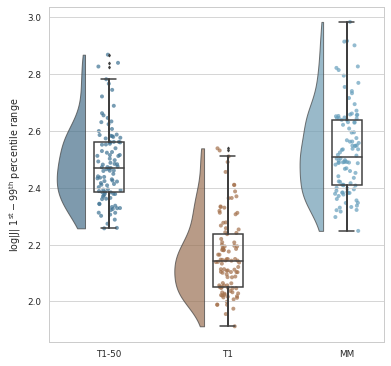

In [32]:
fig_r, ax_r = plt.subplots(nrows=1, ncols=1, sharex='all', figsize=(6,6))

pt.RainCloud(x='reg',\
             y='1_99_percentile_range',\
             data=jac_dets_df_paper,\
             width_viol=0.5,\
             width_box=0.25,\
             palette=sns.cubehelix_palette(n_colors=7, start=0.85, rot=-6, hue=1.0, reverse=True, dark=0.4, light=0.9)[0:7],\
             bw='scott',\
             saturation=0.8,\
             ax=ax_r,
             box_linewidth=1.5,
             alpha=0.7,
             rain_alpha=0.7,\
             point_size=4,\
             box_fliersize=2)

plt.subplots_adjust(top=0.9)
ax_r.set_xlabel('')
ax_r.set_ylabel(r'$log\left|J\right|$ $1^{st} - 99^{th}$ percentile range')

plt.savefig('../../gitlab/multimodal_paper/figs/1-99_percentile_jac_det_range.png', dpi=300,bbox_inches='tight')

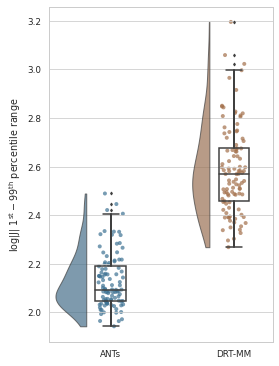

In [38]:
fig_r, ax_r = plt.subplots(nrows=1, ncols=1, sharex='all', figsize=(4,6))

pt.RainCloud(x='reg',\
             y='1_99_percentile_range',\
             data=jac_dets_df_appendix,\
             width_viol=0.5,\
             width_box=0.25,\
             palette=sns.cubehelix_palette(n_colors=7, start=0.85, rot=-6, hue=1.0, reverse=True, dark=0.4, light=0.9)[0:7],\
             bw='scott',\
             saturation=0.8,\
             ax=ax_r,
             box_linewidth=1.5,
             alpha=0.7,
             rain_alpha=0.7,\
             point_size=4,\
             box_fliersize=2)

plt.subplots_adjust(top=0.9)
ax_r.set_xlabel('')
ax_r.set_ylabel(r'$log\left|J\right|$ $1^{st} - 99^{th}$ percentile range')

plt.savefig('../../gitlab/multimodal_paper/figs/1-99_percentile_jac_det_range_appendix.png', dpi=300,bbox_inches='tight')